# **Imports**

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()

import pylab
from statsmodels.stats import proportion

# **Dataset**

In [97]:
# Url to data hosted on github
# Original data source: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016?select=master.csv
data_url = 'https://raw.githubusercontent.com/KylunR/SuicideRateDataAnalysis/master/data.csv'


# Columns of data to read into
features = ["Country", "Year", "Sex", "Age", "Suicides_No", "Population", "Suicides/100K", 
            "Country_Year", "HDI", "GDP", "GDP_Per_Capita", "Generation"]


# Read data into features
data = pd.read_csv(data_url, names=features, sep=',', engine='python', na_values='?', skiprows=1)

# For testing, view table
#data.head()
data.tail()

,Country,Year,Sex,Age,Suicides_No,Population,Suicides/100K,Country_Year,HDI,GDP,GDP_Per_Capita,Generation
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,Uzbekistan2014,0.675,"63,067,077,179",2309,Boomers


# **Data Visualization**

**Suicide Rate for Age Groups**

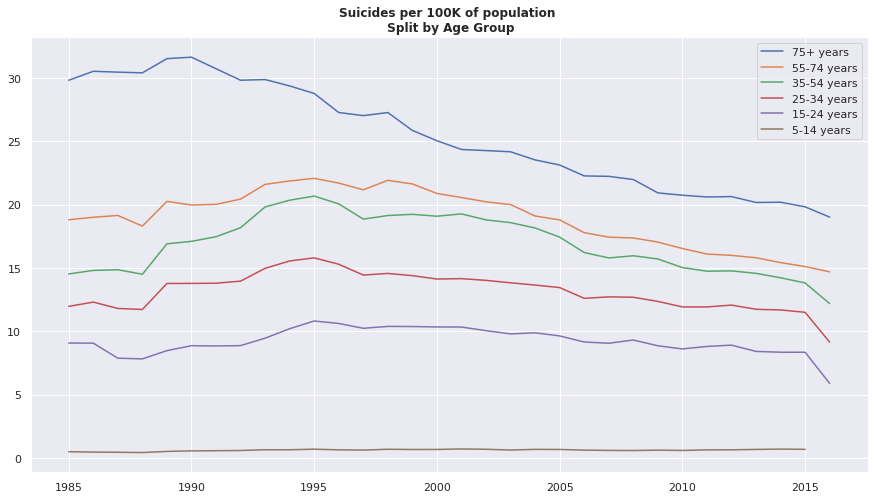

In [98]:
age = data.groupby(['Year','Age']).agg({'Population' : 'sum','Suicides_No': 'sum'}).reset_index()
age['Suicides_Per_Capita'] = age.Suicides_No / age.Population * 100000


def age_plot(agegroup):
    data1 = age.loc[age['Age'] == agegroup,['Year','Suicides_Per_Capita']]
    _ = plt.plot(data1['Year'],data1['Suicides_Per_Capita'])

agegroups = [ '75+ years', '55-74 years', '35-54 years', '25-34 years', '15-24 years', '5-14 years']

plt.figure(figsize = (15,8))

for i in agegroups:
    age_plot(i)
_ = plt.legend(agegroups)
_ = plt.title('Suicides per 100K of population \n Split by Age Group', fontweight='bold')

This graph shows that suicide rate is higher amongst older ages and each age group decreases in suicide rate.  

I found this data interesting, I would like to further research how this has changed in the recent years.

**Suicide Rate for Male vs. Female**

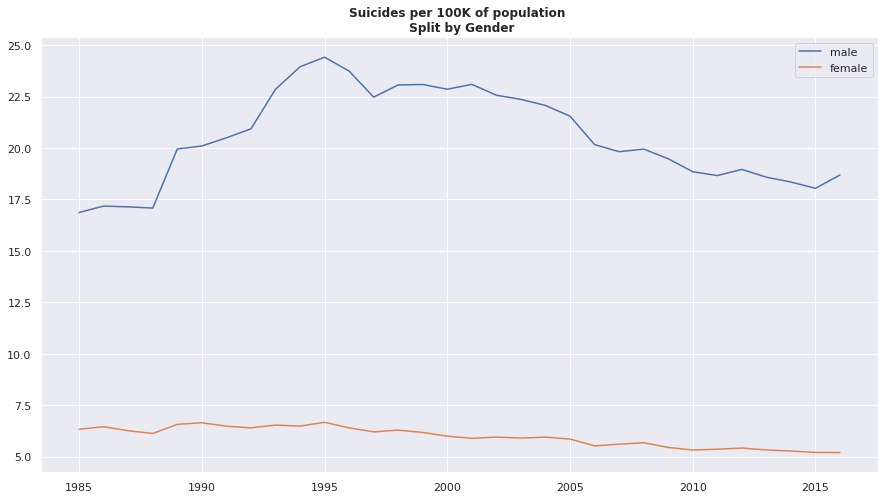

In [99]:
# split by men and woman
gender = data.groupby(['Year','Sex']).agg({'Suicides_No' : 'sum','Population' : 'sum'}).reset_index()
gender['Suicides_Per_Capita'] = gender.Suicides_No / gender.Population * 100000

def gender_plot(sex): 
    data = gender.loc[gender['Sex'] == sex,['Year','Suicides_Per_Capita']]
    plt.plot(data['Year'],data['Suicides_Per_Capita'])

plt.figure(figsize = (15,8))
for i in ('male','female'):
    gender_plot(i)

_ = plt.legend(('male','female'))
_ = plt.title('Suicides per 100K of population \n Split by Gender', fontweight='bold')

This graph shows the suicide is much more prominent for the male population when compared to the female population.

Male suicide rate appears to rise and fall many times over this time period with it ending on a rise.  While female suicide rate has mostly stayed the same and has even slightly decreased over the time period.

# **Data Normalization**

In [100]:
# Data normalization

# Drop Country, Year, Country_Year, HDI
data.drop(['Country', 'Year', 'Country_Year', 'HDI'], axis=1, inplace=True)

# Replace Generation with int values
data.Generation.replace(['Boomers', 'Generation X', 'Generation Z', 'G.I. Generation', 'Millenials', 'Silent'], 
                        ['0', '1', '2', '3', '4', '5'], inplace=True)

# Replace male with 0, female with 1
data.Sex.replace(['male', 'female'], ['0', '1'], inplace=True)

# Remove commas from gdp value
data['GDP'] = data['GDP'].str.replace(',','')

# Used for finding averages of age range
def means(arr):
    return str(np.array(arr).mean())

# Replace age ranges with averages
data.Age.replace(['15-24 years', '25-34 years', '35-54 years', '5-14 years', '55-74 years', '75+ years'], 
                 [means([15, 24]), means([25, 34]), means([35, 54]), 
                  means([5, 14]), means([55, 74]), means([75])], inplace=True)

# Converting string values to numeric
pd.to_numeric(data['Generation']);
pd.to_numeric(data['Sex']);
pd.to_numeric(data['GDP']);

# For testing
data1 = data.copy()

data1.head(100000)

,Sex,Age,Suicides_No,Population,Suicides/100K,GDP,GDP_Per_Capita,Generation
0,0,19.5,21,312900,6.71,2156624900,796,1
1,0,44.5,16,308000,5.19,2156624900,796,5
2,1,19.5,14,289700,4.83,2156624900,796,1
3,0,75.0,1,21800,4.59,2156624900,796,3
4,0,29.5,9,274300,3.28,2156624900,796,0
...,...,...,...,...,...,...,...,...
27815,1,44.5,107,3620833,2.96,63067077179,2309,1
27816,1,75.0,9,348465,2.58,63067077179,2309,5
27817,0,9.5,60,2762158,2.17,63067077179,2309,2
27818,1,9.5,44,2631600,1.67,63067077179,2309,2


# **Classification**

In [101]:
# Classification
# Using classification from: https://www.kaggle.com/elcaiseri/classification-of-high-low-suicide-rates

data['Fatality_Rate'] = np.where(data['Suicides/100K']>data['Suicides/100K'].mean(), 1, 0)

X = np.array(data.drop(['Fatality_Rate', 'Suicides/100K'], 1))
y = np.array(data.Fatality_Rate)

print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Model accuracy is: {0:.2f}".format(accuracy_score(y_test, y_pred) * 100))

[['0' '19.5' 21 ... '2156624900' 796 '1']
 ['0' '44.5' 16 ... '2156624900' 796 '5']
 ['1' '19.5' 14 ... '2156624900' 796 '1']
 ...
 ['0' '9.5' 60 ... '63067077179' 2309 '2']
 ['1' '9.5' 44 ... '63067077179' 2309 '2']
 ['1' '64.5' 21 ... '63067077179' 2309 '0']]
Model accuracy is: 98.56


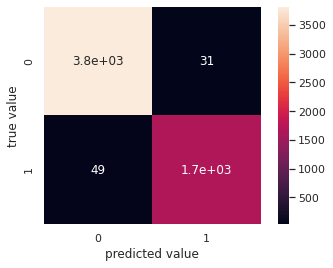

In [102]:
mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, cbar=True)

plt.xlabel('predicted value')
plt.ylabel('true value');

In [103]:
print(X_test[:, 0])

['0' '1' '1' ... '0' '1' '0']


In [104]:
scores = model.predict_proba(X_test)[:, 1]
d = {'target' : y_test,
     'score' : scores,
     'prediction' : y_pred,
     'gender' : X_test[:, 0]}

print(len(y_test))
print(len(scores))
print(len(y_pred))
print(len(X_test[:,0]))


marginals = pd.DataFrame(data=d, columns=['target', 'score', 'prediction', 'gender'])
marginals.head(20)

5564
5564
5564
5564


,target,score,prediction,gender
0,0,0.00,0,0
1,1,0.76,1,1
2,0,0.00,0,1
3,0,0.00,0,1
4,0,0.00,0,1
5,1,1.00,1,0
6,0,0.04,0,0
7,1,0.75,1,0
8,1,0.88,1,0
9,0,0.00,0,0


# **Classification Analysis**



## **Gender**

In [105]:
male_fatality = data.loc[(data['Sex'] == '0')]

print(len(male_fatality['Fatality_Rate']))

# male_fatality_percentage = len(data['Fatality_Rate'] == 0) / len(data['Fatality_Rate'])

male_fatality.head(100000)

13910


,Sex,Age,Suicides_No,Population,Suicides/100K,GDP,GDP_Per_Capita,Generation,Fatality_Rate
0,0,19.5,21,312900,6.71,2156624900,796,1,0
1,0,44.5,16,308000,5.19,2156624900,796,5,0
3,0,75.0,1,21800,4.59,2156624900,796,3,0
4,0,29.5,9,274300,3.28,2156624900,796,0,0
8,0,64.5,1,137500,0.73,2156624900,796,3,0
...,...,...,...,...,...,...,...,...,...
27809,0,29.5,318,2739150,11.61,63067077179,2309,4,0
27811,0,64.5,144,1271111,11.33,63067077179,2309,0,0
27812,0,19.5,347,3126905,11.10,63067077179,2309,4,0
27813,0,75.0,17,224995,7.56,63067077179,2309,5,0


      Sex   Age  Suicides_No  ...  GDP_Per_Capita  Generation Fatality_Rate
2       1  19.5           14  ...             796           1             0
5       1  75.0            1  ...             796           3             0
6       1  44.5            6  ...             796           5             0
7       1  29.5            4  ...             796           0             0
9       1   9.5            0  ...             796           1             0
...    ..   ...          ...  ...             ...         ...           ...
27814   1  29.5          162  ...            2309           4             0
27815   1  44.5          107  ...            2309           1             0
27816   1  75.0            9  ...            2309           5             0
27818   1   9.5           44  ...            2309           2             0
27819   1  64.5           21  ...            2309           0             0

[13910 rows x 9 columns]
Model accuracy is: 98.49


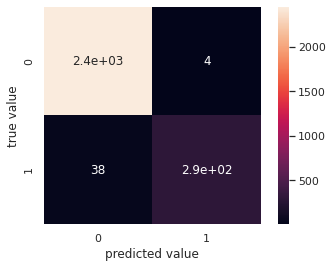

In [106]:
data1['Fatality_Rate'] = np.where(data1['Suicides/100K']>data1['Suicides/100K'].mean(), 1, 0)
data1 = data1[data1['Sex'] == '1']

print(data1)
data1.head()


X1 = np.array(data1.drop(['Fatality_Rate', 'Suicides/100K'], 1))
y1 = np.array(data1.Fatality_Rate)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)

model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(X1_train, y1_train)

y1_pred = model1.predict(X1_test)

print("Model accuracy is: {0:.2f}".format(accuracy_score(y1_test, y1_pred) * 100))

mat = confusion_matrix(y1_test, y1_pred)

sns.heatmap(mat, square=True, annot=True, cbar=True)

plt.xlabel('predicted value')
plt.ylabel('true value');


**Seperation**

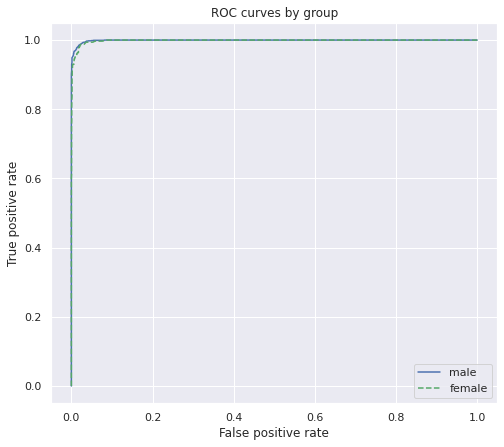

In [107]:
male = marginals[marginals['gender'] == '0']
#the metrics.roc_curve method from sklearn library takes the labels, and scores 
# and reutrn false positive, true positive rate and a threshold which we ignore 

fpr_male, tpr_male, t_ = metrics.roc_curve(male['target'], male['score'])


female = marginals[marginals['gender'] == '1']
fpr_female, tpr_female, _ = metrics.roc_curve(female['target'], female['score'])


plt.figure(1, figsize=(8, 7))
plt.title('ROC curves by group')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.plot(fpr_male, tpr_male, label='male', linestyle='-', color='b')
plt.plot(fpr_female, tpr_female, label='female', linestyle='--', color='g')
plt.margins(x=0.05, y=0.05)

plt.legend()
plt.show()

**Sufficieny**


In [0]:
# From UCI adult data set.ipynb

def score_range(p, q, df):
    """Returns number of success and observations for given bucket."""
    gp = df[df['score'] > p]
    lq = gp[gp['score'] <= q]
    return [sum(lq['target']), len(lq['target'])]

def get_frequencies(marginals, num_buckets=10):
    """Returns list of lists. The first list is successes 
    for all buckets, the second one is total counts."""
    ts = np.linspace(0, 1, num_buckets+1)
    frequencies = [[],[]]
    for i in range(num_buckets):
        b = score_range(ts[i], ts[i+1], marginals)
        frequencies[0].append(b[0])
        frequencies[1].append(b[1])
    return frequencies

def plot_confidence(plt, xs, n_succs, n_obss, label, linestyle, color, confidence=0.95):
    """Plot a graph with confidence intervals where
       each x corresponds to a binomial random variable in which n_obs observations led to n_succ successes"""
    n_succs, n_obss = np.array(n_succs), np.array(n_obss)
    conf_lbs, conf_ubs = proportion.proportion_confint(n_succs, n_obss, alpha=1-confidence)
    pylab.fill_between(xs, conf_ubs, conf_lbs, alpha=.2, color=color)
    pylab.plot(xs, n_succs / n_obss, '.-', label=label, linestyle=linestyle, color=color)

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/proportion.py:86: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 0, 'Score decile')

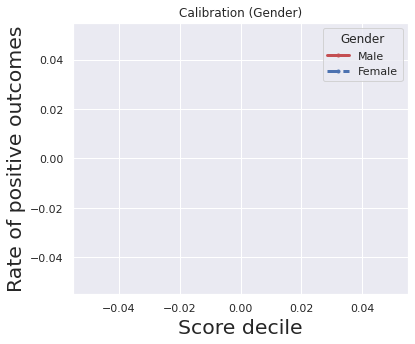

In [114]:
genders = ['Male', 'Female']
styles = ['-', '--']
colors = ['r', 'b']
deciles = range(1, 10+1)
pylab.rc('font',  size='17')
pylab.rc('axes', labelsize='large')
pylab.rc('lines', linewidth=3)

pylab.figure(1, figsize=(6, 5))
pylab.title('Calibration (Gender)')

for i in range(2):
    gender = genders[i]
    num = get_frequencies(marginals[marginals['gender']== gender])
    plot_confidence(plt, deciles, num[0], num[1], gender, styles[i], colors[i])

pylab.legend(title="Gender")
pylab.ylabel('Rate of positive outcomes')
pylab.xlabel('Score decile')
#pylab.tight_layout()